## Apply the battery to our data and calculate the cost with and without battery (and logic)

### Ready the dataset

In [ ]:
# Load peak hour price data and meter-id data
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt

df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

# Load json file hour_lookup_price.json
with open('data/hour_lookup_price_dict.json') as json_file:
    hour_lookup_price = json.load(json_file)


In [ ]:
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [ ]:
series_prod = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3", "prod", start="2016-09-04 22:00:00+00:00", end = "2019-05-14 21:00:00+00:00")
series_cons = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3", "cons", start="2016-09-04 22:00:00+00:00", end = "2019-05-14 21:00:00+00:00")

In [ ]:
# Merge series
series_merge = pd.merge(series_prod, series_cons, how="outer", left_index=True, right_index=True)
# Rename num_kwh_normalized_x and num_kwh_normalized_y
series_merge.columns = ["num_kwh_prod", "num_kwh_cons"]

# Add column called power_yield with the difference between prod and cons
series_merge["power_yield"] = series_merge["num_kwh_prod"] - series_merge["num_kwh_cons"]
# add column current index as timeslot and reset index
series_merge["timeslot"] = series_merge.index
series_merge = series_merge.reset_index(drop=True)

print(series_merge.head())

### Calculate Cost without battery

In [ ]:
# Add column with the price based on the power_yield
def get_price(power_yield, hour):
    if power_yield >= 0:
        return 0
    else:
        return -power_yield * hour_lookup_price[str(hour)]

series_no_battery = series_merge.copy()

# Apply function to dataframe and add column
series_no_battery["price"] = series_no_battery.apply(lambda row: get_price(row["power_yield"], row["timeslot"].hour), axis=1)


Without battery cost

In [14]:
start, end = series_no_battery["timeslot"].iloc[0], series_no_battery["timeslot"].iloc[-1]
print(f"Cost for period: {start} to {end} is: ", round(series_no_battery["price"].sum(), 0), " NOK without VAT")

Cost for period: 2016-09-04 22:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  62171.0  NOK without VAT


### Calculate Cost with battery without logic

In [27]:
# Initialise battery
from battery import Battery
battery = Battery()
series_battery = series_merge.copy()
print(series_battery.head())

   num_kwh_prod  num_kwh_cons  power_yield                  timeslot
0           0.0           0.0          0.0 2016-09-04 22:00:00+00:00
1           0.0           2.0         -2.0 2016-09-04 23:00:00+00:00
2           0.0           1.0         -1.0 2016-09-05 00:00:00+00:00
3           0.0           1.0         -1.0 2016-09-05 01:00:00+00:00
4           0.0           1.0         -1.0 2016-09-05 02:00:00+00:00


In [28]:
# Def function to apply battery to dataframe
def logic(power_yield):
    # If surplus - charge battery
    if power_yield > 0:
       battery.charge(power_yield)

    # If deficit - discharge battery
    elif power_yield < 0:
        battery.discharge(power_yield)
    
    # If power_yield is 0 - do nothing
    else:
        pass

    # Return battery capacity
    return battery.get_current_capacity()

# Add column with battery capacity
series_battery["battery_capacity"] = series_battery.apply(lambda row: logic(row["power_yield"]), axis=1)

In [29]:
battery = Battery()
# Def function to apply battery to dataframe
def logic(power_yield):
    # If surplus - charge battery
    if power_yield >= 0:
       battery.charge(power_yield)

    # If deficit - discharge battery
    elif power_yield < 0:
        battery.discharge(power_yield)

    # Return battery capacity
    return battery.get_over_under_charge()

series_battery["beyond_battery_capacity"] = series_battery.apply(lambda row: logic(row["power_yield"]), axis=1)

In [30]:
print(series_battery.head())

   num_kwh_prod  num_kwh_cons  power_yield                  timeslot  \
0           0.0           0.0          0.0 2016-09-04 22:00:00+00:00   
1           0.0           2.0         -2.0 2016-09-04 23:00:00+00:00   
2           0.0           1.0         -1.0 2016-09-05 00:00:00+00:00   
3           0.0           1.0         -1.0 2016-09-05 01:00:00+00:00   
4           0.0           1.0         -1.0 2016-09-05 02:00:00+00:00   

   battery_capacity  beyond_battery_capacity  
0               0.0                      0.0  
1               0.0                     -2.0  
2               0.0                     -1.0  
3               0.0                     -1.0  
4               0.0                     -1.0  


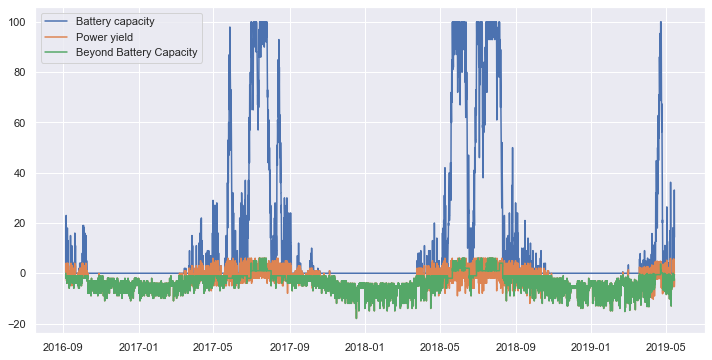

In [35]:
# plot battery capacity and power yield in same plot with plotly
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery["timeslot"], series_battery["battery_capacity"], label="Battery capacity")
ax.plot(series_battery["timeslot"], series_battery["power_yield"], label="Power yield")
ax.plot(series_battery["timeslot"], series_battery["beyond_battery_capacity"], label="Beyond Battery Capacity")
ax.legend()
plt.show()

In [36]:
# plot battery capacity and power yield in same plot with plotly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=series_battery["timeslot"], y=series_battery["battery_capacity"], name="Battery capacity"))
fig.add_trace(go.Scatter(x=series_battery["timeslot"], y=series_battery["power_yield"], name="Power yield"))
fig.add_trace(go.Scatter(x=series_battery["timeslot"], y=series_battery["beyond_battery_capacity"], name="Beyond Battery Capacity"))
fig.show()

In [33]:
def get_price_battery(demand, hour):
    return -demand * hour_lookup_price[str(hour)]

series_battery["price"] = series_battery.apply(lambda row: get_price_battery(row["beyond_battery_capacity"], row["timeslot"].hour), axis=1)

### Price with battery without logic

In [34]:
start, end = series_battery["timeslot"].iloc[0], series_battery["timeslot"].iloc[-1]
print(f"Cost for period: {start} to {end} is: ", round(series_battery["price"].sum(), 0), " NOK without VAT")

Cost for period: 2016-09-04 22:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  59259.0  NOK without VAT


## Estimate cost with battery and with logic

if next hourøs estimated cost is higher than our current - we wait discharging our battery